<a href="https://colab.research.google.com/github/viriditass/Papers/blob/main/Malware_Detection_by_Eating_a_Whole_EXE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Malware Detection by Eating a Whole EXE**

논문 링크: https://arxiv.org/abs/1710.09435

본 논문에서는 raw byte sequences에서 malware를 detection하는 방법을 제안한다.

먼저 malware detection 환경을 구축하기 위해 사용할 dataset을 구해야 한다. 첫번째 방법은 동적 분석(dynamic analysis)인데, Virtual Machine과 같은 특수 환경에서 malware를 실행시켜 API 호출, 실행된 명령, access된 IP address 등을 이용하는 것이다. 하지만 당연하게도 이 작업은 malware가 분석 시도를 회피하거나 수집된 data와 실제 환경이 달라 불일치가 생기는 등 여러가지 한계점이 있기에 이는 장기적인 솔루션에 적합하지 않는다.

따라서 본 논문의 저자들은 실행하지 않고도 해당 파일의 정보를 얻을 수 있는 정적 분석(static analysis) 방법을 선택했다. 바로 프로그램이 사용하는 API나 어느 메모리 주소에 파일이 로딩되는지 등을 모두 알 수 있는 PE 파일을 vector화 시키는 것이다.

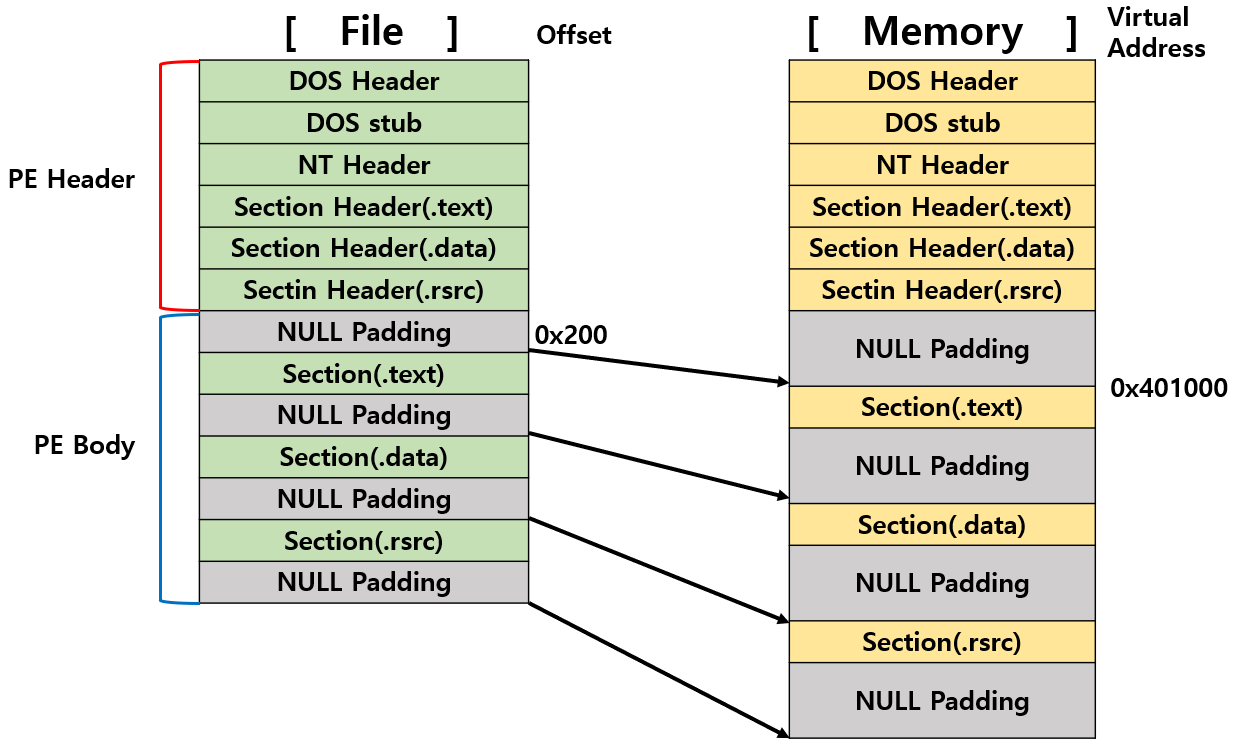

PE 파일이란, EXE, SCR, DLL과 같은 윈도우에서 돌아가는 모든 파일이다. PE 파일의 구조는 위와 같다. PE Header에는 다양한 정보들이 구조체 형식으로 저장되어 있으며, 이때 PE Header는 DOS Header로부터 Section Header까지이며 그 외의 Section들이 합쳐서 PE Body가 된다.

## **MalConv**

PE 파일을 벡터화 시키면 매우 긴 sequence가 생성된다. 따라서 본 논문은 기존에 긴 sequence를 대상으로 한 논문들을 참고하였다. 예를 들어 WaveNet은 raw audio를 처리하기 위한 모델이다. 하지만 PE 파일을 벡터화한 sequence가 2배는 더 길다는 점이 문제다.

### **Architecture**

본 논문은 PE 파일을 벡터화한 매우 긴 sequence에서 malware를 찾아내기 위해 해당 sequnce를 전체적으로 잘 분석해내는 모델 구조를 고안해냈다.

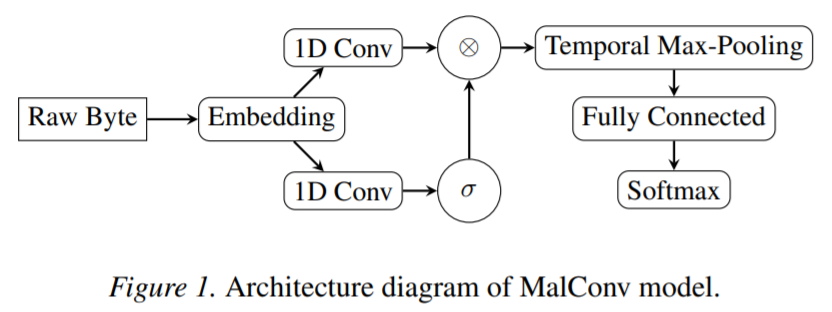

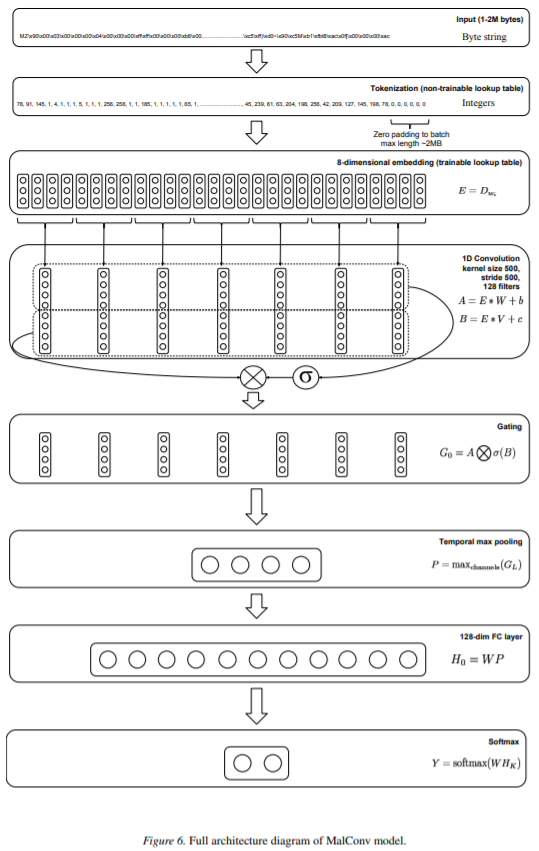

기본적인 MalConv model의 구조는 위의 그림 Figure 1과 같다. 그리고 최종적인 MalConv model의 구조는 위의 그림 Figure 6과 같다. 여기서 재미있는 사실은 batch normalization이 오히려 성능을 악화시켜 DeCov regularization을 사용하였다.

또한, RNN말고 Bidirectional RNNs이나 다양한 attention model을 사용하여 실험을 해봤지만 재미있게도 RNN이 가장 성능이 좋았다고 한다. 그리고 large convolution layer를 사용하는 방법도 사용해봤지만 기존 dataset에 대한 acc는 95%로 좋게 나왔지만, 새로운 dataset에 일반화하는 것은 종종 실패하였다.

### **Pytorch**

위의 그림 Figure 1을 pytorch로 구현해보았다.

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MalConv(nn.Module):
    def __init__(self, input_length=2000000, kernel_size=500):
        super(MalConv, self).__init__()

        self.embed = nn.Embedding(257, 8, padding_idx=0)

        self.conv1 = nn.Conv1d(in_channels=4, out_channels=128, kernel_size=kernel_size, bias=True)
        self.conv2 = nn.Conv1d(in_channels=4, out_channels=128, kernel_size=kernel_size, bias=True)

        self.pool = nn.MaxPool1d(int(input_length/kernel_size))

        self.fc1 = nn.Linear(128, 128)
        self.fc2 = nn.Linear(128, 1)

        self.sig = nn.Sigmoid()

    def forward(self, x):
        x = self.embed(x)
        x = torch.transpose(x,-1,-2)
        
        cnn_value = self.conv1(x.narrow(-2,0,4))
        gating_weight = self.sigmoid(self.con2(x.narrow(-2,4,4)))

        x = cnn_value * gating_weight
        x = self.pool(x)

        x = x.view(-1,128)
        x = self.fc1(x)
        x = self.fc2(x)

        return x

## **Experiments**

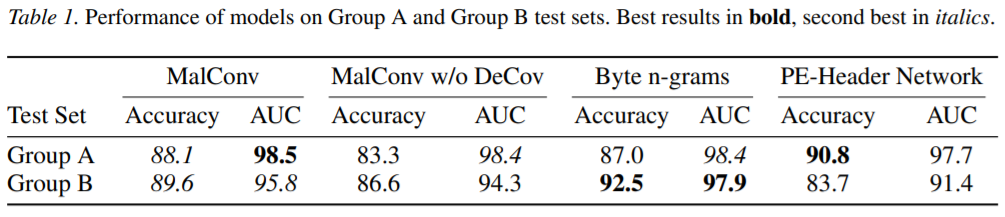

위의 표 Table 1을 보면 Byte n-grams의 경우 Group A와 B의 정확도 차이가 있기 때문에 overfitting이 일어난 것을 알 수 있다. 또한, Byte n-grams의 경우는 단일 byte의 변경에 취약하다. 그리고 PE-Header Network의 경우는 Group B에 대해 acc나 auc가 상당히 떨어진 것을 알 수 있다. 이와는 대조적으로 MalConv는 모든 데이터에 대해 성능이 가장 균형을 잘 이루었다.

또한, DeCov regularization을 사용했을때 최대 acc가 4.8 오르는 것을 알 수 있다.

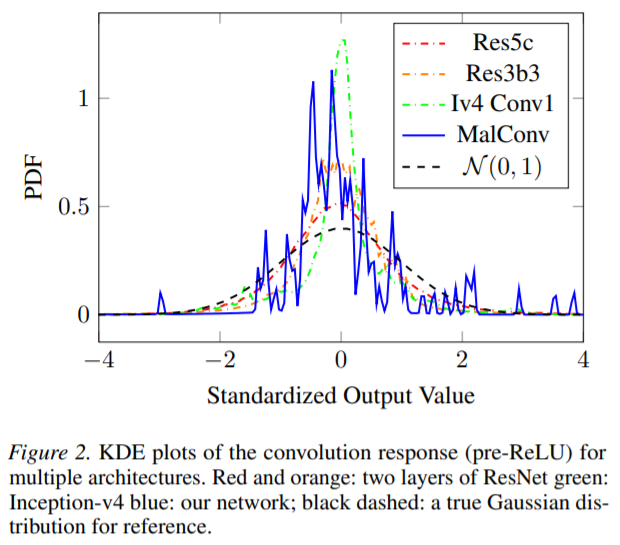

재미있는 사실은 **batch normalization**로 인해 모델이 학습을 제대로 하지 못한다는 점이다. BN은 더 빠른 수렴과 일반화로 인해 현재까지도 여러 딥러닝 모델에 활용되는 기법이지만, 해당 domain에서는 좋은 결과를 얻지 못했다. 실제로 BN을 넣어 실험을 한 결과 모델의 정확도가 train 60%, test 50%로 성능이 더욱 악화된 것을 알 수 있다. 그 원인은 RNN과 같은 민감한 application에 안좋은 성능을 보이는 BN의 고유한 특징 때문이다. (그로 인해 layer normalization 등 여러 기법이 나왔다.) 위의 그림 Figure 2를 보면 네트워크의 activation 분포가 불안정하는 것을 알 수 있다.